# Devito LSRTM

This notebook performs LSRTM with sparsifying constraints on the model using FISTA.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import devito

from examples.seismic import Model
from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Receiver
from examples.seismic import plot_velocity, plot_shotrecord

from pylops.waveeqprocessing.twoway import AcousticWave2D
from pylops.optimization.sparsity import fista
from pylops.utils import dottest

devito.configuration['log-level'] = 'ERROR'

## Velocity model

In [2]:
#model parameter
origshape = (1360, 280)
shape = (500, 280)
spacing = (12.5, 12.5)
origin = (0, 0)

#geometry arrange
nsrc = 21
nrec = 200

# other modelling params
nbl=30 # Number of boundary layers around the domain
space_order=6 # Space order of the simulation
f0 = 0.015 # Source peak frequency
tn=5000 # Total simulation time

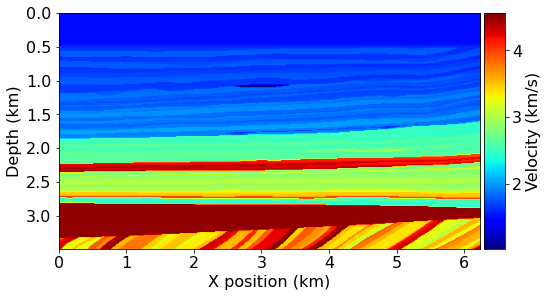

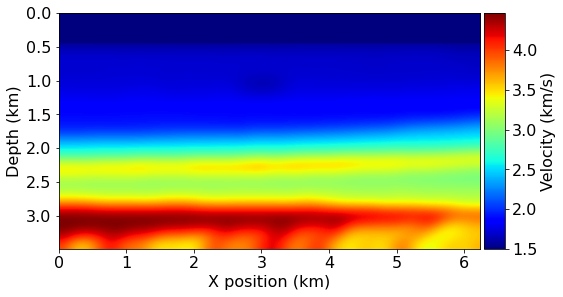

In [3]:
data_path = "../data/lsm/marmousi.bin"

# Get true model
vp = 1e-3 * np.fromfile(data_path, dtype='float32', sep="") # devito expects velocity to have km/s as units
vp = vp.reshape(origshape)[:shape[0],:shape[1]]
true_model = Model(space_order=space_order, vp=vp, origin=origin, shape=shape,
                   dtype=np.float32, spacing=spacing, nbl=nbl, bcs="damp")

# Get smooth model
v0 = scipy.ndimage.gaussian_filter(vp, sigma=10)    
v0[:,:36] = 1.5 # Do not smooth water layer
smooth_model = Model(space_order=space_order, vp=v0, origin=origin, shape=shape,
                     dtype=np.float32, spacing=spacing, nbl=nbl, bcs="damp")

# display
plot_velocity(true_model)
plot_velocity(smooth_model)

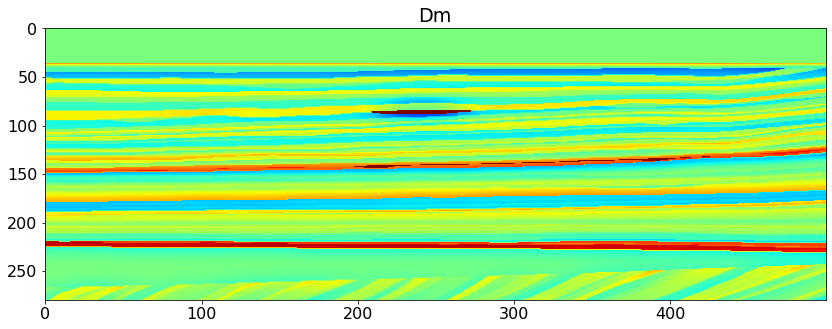

In [4]:
# Compute initial born perturbation from m - m0
dm = (vp**(-2) - v0**(-2))

plt.figure(figsize=(14, 5))
plt.imshow(dm.T, 
           cmap='jet', vmin=-1e-1, vmax=1e-1)
plt.title('Dm')
plt.axis('tight');

In [5]:
src_x = np.linspace(0, shape[0]*spacing[0], num=nsrc)
src_z = 20. 

rec_x = np.linspace(0, shape[0]*spacing[0], num=nrec)
rec_z = 20.

Aop = AcousticWave2D(shape, origin, spacing, v0 * 1e3,
                     src_x, src_z, rec_x, rec_z, 0., tn, 'Ricker',
                     space_order=6, nbl=100, f0=15,
                     dtype="float32", name="A")

## Data

In [6]:
dobs = Aop @ dm

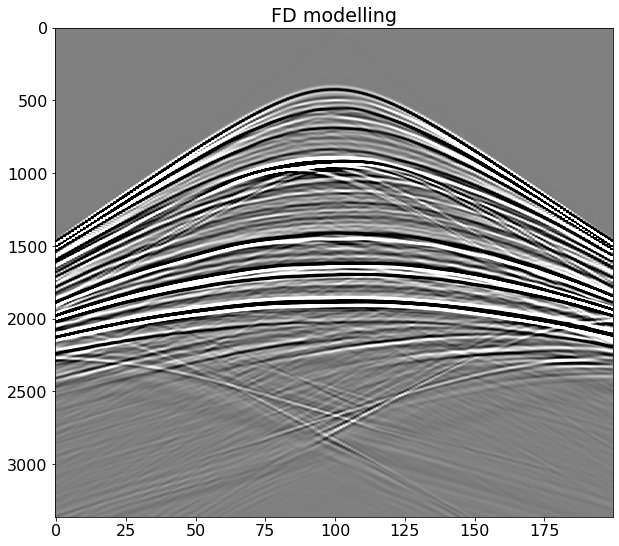

In [7]:
plt.figure(figsize=(10, 9))
plt.imshow(dobs[Aop.geometry.nsrc//2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, 
           cmap='gray', vmin=-0.1, vmax=0.1)
plt.title('FD modelling')
plt.axis('tight');

## Image

In [8]:
dmrtm = Aop.H @ dobs

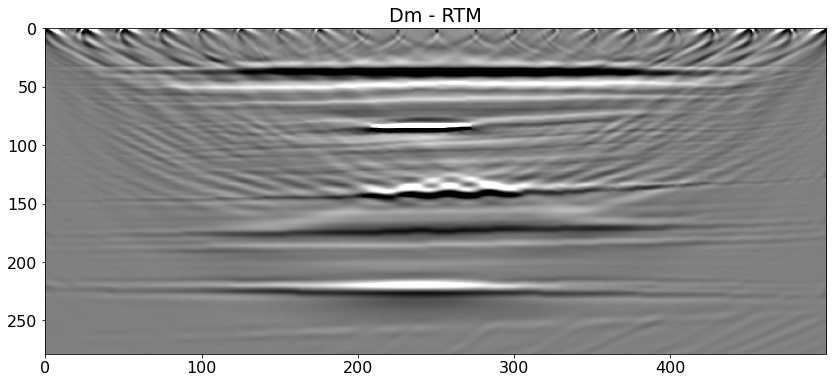

In [9]:
plt.figure(figsize=(14, 6))
plt.imshow(np.diff(dmrtm, axis=1).T, cmap='gray', vmin=-3e2, vmax=3e2)
plt.title('Dm - RTM')
plt.axis('tight');

## LSRTM

In [10]:
Aop.reset_count()
Aop1 = Aop.H @ Aop
maxeig = 843365.94 # Aop1.eigs(1, symmetric=True, uselobpcg=True, niter=8, tol=1e2)[0]

In [11]:
maxeig, Aop.matvec_count

(843365.94, 0)

In [12]:
dmlsrtm, _, rhist = fista(Aop, dobs.ravel(), niter=50, eps=7e-2, alpha=.99/maxeig, show=True)
dmlsrtm = dmlsrtm.reshape(shape)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 14120400 rows and 140000 cols
eps = 7.000000e-02	tol = 1.000000e-10	niter = 50
alpha = 1.173868e-06	thresh = 4.108537e-08
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -1.8029e-04         3.895e+05   3.896e+05   3.090e-01
     2      -7.2822e-04         3.430e+05   3.430e+05   2.444e-01
     3      -1.4499e-03         3.017e+05   3.017e+05   2.620e-01
     4      -2.3104e-03         2.677e+05   2.677e+05   2.649e-01
     5      -3.2211e-03         2.405e+05   2.405e+05   2.597e-01
     6      -4.1101e-03         2.188e+05   2.188e+05   2.515e-01
     7      -4.9125e-03         2.009e+05   2.009e+05   2.436e-01
     8      -5.5816e-03         1.858e+05   1.858e+05   2.373e-01
     9      -6.0876e-03         1.726e+05   1.727e+05   2.325e-01
    10     

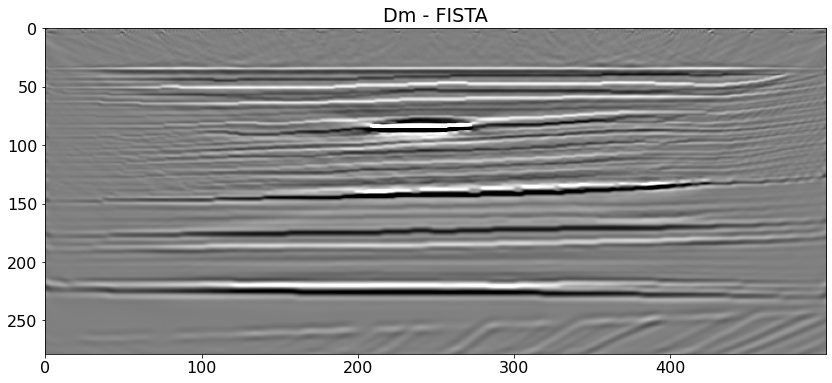

In [13]:
plt.figure(figsize=(14, 6))
plt.imshow(np.diff(dmlsrtm, axis=1).T, cmap='gray', vmin=-3e-2, vmax=3e-2)
plt.title('Dm - FISTA')
plt.axis('tight');

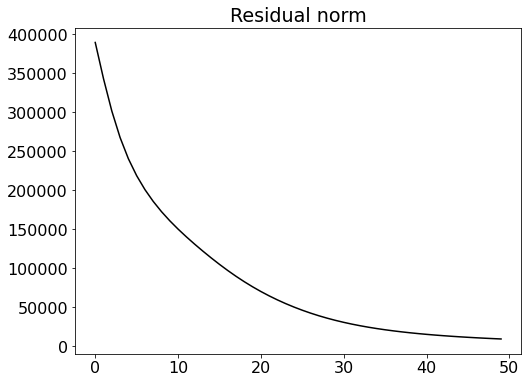

In [14]:
plt.plot(rhist, 'k')
plt.title('Residual norm');

In [15]:
# Recreate data from lsrtm image
dlsrtm = Aop @ dmlsrtm

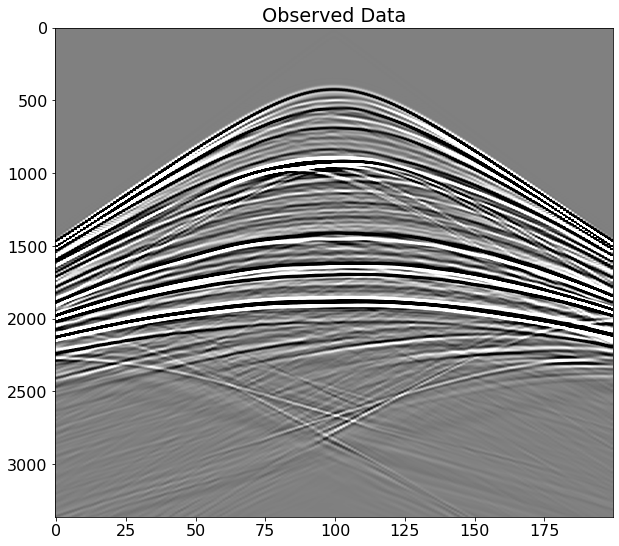

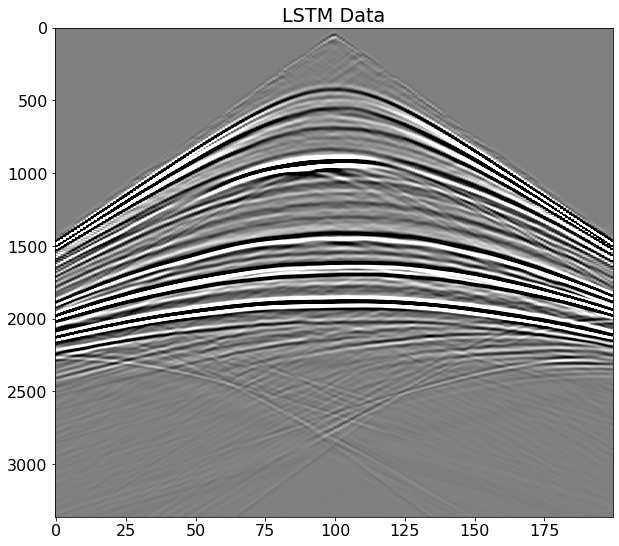

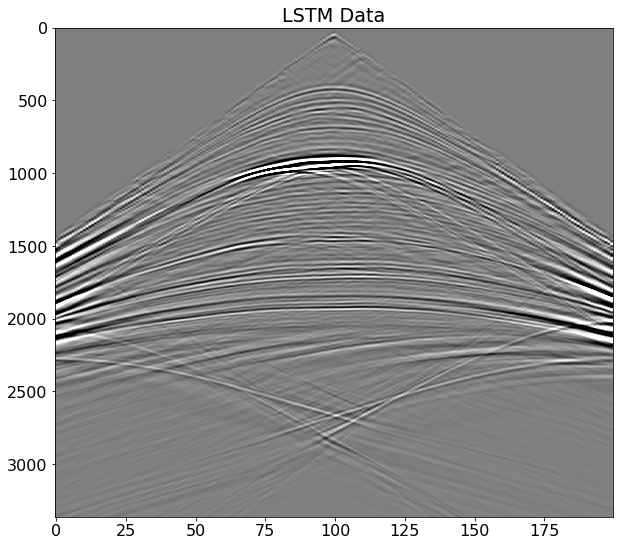

In [16]:
plt.figure(figsize=(10, 9))
plt.imshow(dobs[Aop.geometry.nsrc//2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, 
           cmap='gray', vmin=-0.1, vmax=0.1)
plt.title('Observed Data')
plt.axis('tight')

plt.figure(figsize=(10, 9))
plt.imshow(dlsrtm[Aop.geometry.nsrc//2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, 
           cmap='gray', vmin=-0.1, vmax=0.1)
plt.title('LSTM Data')
plt.axis('tight')

plt.figure(figsize=(10, 9))
plt.imshow(dobs[Aop.geometry.nsrc//2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T - 
           dlsrtm[Aop.geometry.nsrc//2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, 
           cmap='gray', vmin=-0.1, vmax=0.1)
plt.title('LSTM Data')
plt.axis('tight');